
# Data shifted Preprocess For PTB data 
The default preprocessing step is what we conclude in our report. 
You can check below what should be input for this notebook and what would be the output if necessary.

Processing **steps** for PTB dataset:   
    resample: Oversampling  
    rescaling: StandardScaler  


**Input** : raw data:  
ptbdb_normal.csv  
ptbdb_abnormal.csv  

**Output** : Sampled and Scaled data:   
ptb_train_shift_standard_oversampling.csv  
ptb_test_shift_standard_oversampling.csv


In [37]:
import sys
import os
data_path = ''
data_output_path = ''
# Check if the environment is Google Colab
if 'google.colab' in sys.modules:
    print("Running on Google Colab")
    # Install required libraries
    !pip install scikit-learn -q
    !pip install pandas -q
    !pip install numpy -q
    !pip install imbalanced-learn -q


    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    # set the path where the csv file stored in your google drive. 
    data_path = '/content/drive/MyDrive/Heartbeat_Project/'
    data_output_path = data_path
    
else:
    print("Running on local environment")

    current_path = os.getcwd()
    print("Current working directory:", current_path)
    data_path = '../data/raw/'
    data_output_path = '../data/processed/'


Running on local environment
Current working directory: c:\Users\Ping\Documents\GitHub\heartbeat-analysis-ai\notebooks


In [38]:
# Verify installation and import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt

RawFiles = dict({
    'normal': data_path +  'ptbdb_normal.csv',
    'abnormal': data_path +  'ptbdb_abnormal.csv',
})

OutputFiles = dict({
    'test': data_output_path +  'ptb_test_shift_standard_oversampling.csv',
    'train': data_output_path +  'ptb_train_shift_standard_oversampling.csv',
})

In [39]:
def addColumnsToDataframe(df):
    """
    As the dataset is composed with 188 columns with the 188th columns as the category values,
    so we give the last column the name 'target', others named with 'c_182'
    """
    num_columns= df.shape[1]
    feature_col_name = ['c_' + str(i) for i in range(0, num_columns - 1)]
    df_columns = feature_col_name + ['target']
    df.columns = df_columns
    return df

def convertColumnAsInt(df, column):
    """
    As the category value is in float type. We want to get the int to identify the category.
    """
    df[column] = df[column].astype(int)
    return df
def plotDataAsLine(df, first):
    data = df.head(first)
    for index, row in data.iterrows():
        plt.plot(data.columns, row)

    plt.grid(True)
    plt.show()

In [40]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

ptb_normal = pd.read_csv(RawFiles.get('normal'), header=None)
ptb_abnormal = pd.read_csv(RawFiles.get('abnormal'), header=None)

ptb_data = pd.concat([ptb_normal, ptb_abnormal], axis=0, ignore_index=True)
ptb_data = ptb_data.sample(frac=1).reset_index(drop=True)

ptb_data = addColumnsToDataframe(ptb_data)  
ptb_data = convertColumnAsInt(ptb_data, 'target') 

ptb_data = ptb_data.dropna(axis=0)

ptb_train, ptb_test = train_test_split(ptb_data, test_size=0.2, random_state=42)


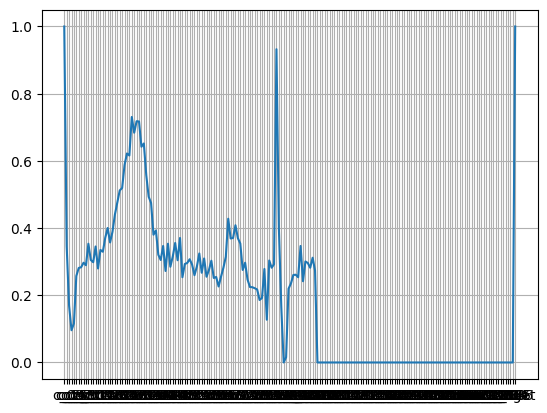

In [41]:
plotDataAsLine(ptb_train, 1)

Shift data

In [42]:
import pandas as pd
from scipy.signal import find_peaks
import os
import numpy as np

# Function to find the Top-N highest and lowest peaks in a single signal
def find_top_n_peaks(signal, n=5):
    # Find highest peaks
    high_peaks, _ = find_peaks(signal)
    high_peaks_values = signal[high_peaks]
    top_high_peaks = sorted(zip(high_peaks, high_peaks_values), key=lambda x: -x[1])[:n]

    # Find lowest peaks 
    low_peaks, _ = find_peaks(signal * -1) # -1 means invert the signal to find the lowest peaks
    low_peaks_values = signal[low_peaks]
    top_low_peaks = sorted(zip(low_peaks, low_peaks_values), key=lambda x: x[1])[:n]

    return top_high_peaks, top_low_peaks

# Function to find global Top-N peaks across the entire dataset (for each row)
def find_global_top_peaks(data, n=5):
    top_high_peaks_global = []
    top_low_peaks_global = []

    for _, row in data.iterrows():
        signal = row.values
        top_high_peaks, top_low_peaks = find_top_n_peaks(signal, n)
        top_high_peaks_global.append(top_high_peaks)
        top_low_peaks_global.append(top_low_peaks)

    return top_high_peaks_global, top_low_peaks_global

# Function to align signals based on a specific peak index
def align_signals(data, peak_index, target_column=None):
    if target_column is None:
        target_column = data.shape[1] // 2

    aligned_data = []
    for _, row in data.iterrows():
        # Calculate the shift required based on the peak index
        shift = target_column - peak_index
        shifted_row = np.roll(row, shift)
        aligned_data.append(shifted_row)

    return pd.DataFrame(aligned_data)

# Target column name
target_column = 'target'
target_classes = ptb_train[target_column].unique()

# Combined DataFrames for training and test datasets
combined_train_data = []
combined_test_data = []

# Process each class in the training and test datasets
for c in target_classes:
    # Filter data by class
    train_class_data = ptb_train[ptb_train[target_column] == c].iloc[:, :-1]
    test_class_data = ptb_test[ptb_test[target_column] == c].iloc[:, :-1]

    # Find Top-5 highest and lowest peaks for the training dataset of the current class
    top_high_train, top_low_train = find_global_top_peaks(train_class_data, n=5)
    # Center signals on the first highest peak
    aligned_train_high = align_signals(train_class_data, top_high_train[0][0][0])  # Top-1 High Peak
    # Center signals on the first lowest peak
    aligned_train_low = align_signals(train_class_data, top_low_train[0][0][0])  # Top-1 Low Peak

    # Find Top-5 highest and lowest peaks for the test dataset of the current class
    top_high_test, top_low_test = find_global_top_peaks(test_class_data, n=5)
    # Center signals on the first highest peak
    aligned_test_high = align_signals(test_class_data, top_high_test[0][0][0])  # Top-1 High Peak
    # Center signals on the first lowest peak
    aligned_test_low = align_signals(test_class_data, top_low_test[0][0][0])  # Top-1 Low Peak
    
    # Combine high and low aligned versions (You may choose one or both alignments depending on your needs)
    aligned_train = (aligned_train_high + aligned_train_low) / 2
    aligned_test = (aligned_test_high + aligned_test_low) / 2

    # Add a column for the target variable
    aligned_train['target'] = c
    aligned_test['target'] = c

    # Append the aligned data to the final lists for training and test datasets
    combined_train_data.append(aligned_train)
    combined_test_data.append(aligned_test)

# Combine all classes into two final DataFrames (one for training, one for testing)
shifted_ptb_train = pd.concat(combined_train_data).sample(frac=1).reset_index(drop=True)
shifted_ptb_test = pd.concat(combined_test_data).sample(frac=1).reset_index(drop=True)

# Rename columns to c_0, c_1, ..., c_187, and 'target'
feature_columns = [f'c_{i}' for i in range(shifted_ptb_train.shape[1] - 1)] + ['target']
shifted_ptb_train.columns = feature_columns
shifted_ptb_test.columns = feature_columns



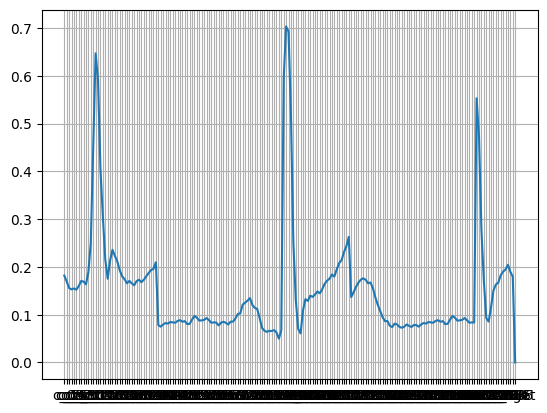

In [43]:
plotDataAsLine(shifted_ptb_train, 1)

Rescaler with standard scaler    
Resampling with randomoversampler

In [44]:

X_train = shifted_ptb_train.drop(columns=['target'], inplace=False) # drop the target column
X_test = shifted_ptb_test.drop(columns=['target'], inplace=False) # drop the target column

y_train = shifted_ptb_train['target'] # only the target column
y_test = shifted_ptb_test['target'] # only the target column



randomOverSampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = randomOverSampler.fit_resample(X_train, y_train)

# rescaler with StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# convert resampling rescaling data back to dataframe to concat
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=[f'c_{i}' for i in range(X_train_scaled.shape[1])])
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=[f'c_{i}' for i in range(X_test_scaled.shape[1])])
y_train_resampled_df = pd.DataFrame(y_train_resampled, columns=['target'])
y_test_df = pd.DataFrame(y_test, columns=['target'])

# concat X_train, y_train(reset index to avoid join)
ptb_train_shift_standard_oversampling = pd.concat(
    [
        X_train_scaled_df, y_train_resampled_df
    ], axis=1)

ptb_test_shift_standard_oversampling = pd.concat(
    [  
        X_test_scaled_df, y_test_df.reset_index(drop=True)
    ], axis=1)


In [45]:
# save clean data to 
# Speichern der Trainings- und Testdaten mit Header
ptb_train_shift_standard_oversampling.to_csv(OutputFiles.get('train'), index=False, header=True)
ptb_test_shift_standard_oversampling.to_csv(OutputFiles.get('test'), index=False, header=True)

# show some info
print("Data Preprocessing is done and saved to the output folder")
print("Train data shape: ", ptb_train_shift_standard_oversampling.shape)
print("Test data shape: ", ptb_test_shift_standard_oversampling.shape)
print("Data saved to: ", OutputFiles.get('train'))
print("Data saved to: ", OutputFiles.get('test'))

Data Preprocessing is done and saved to the output folder
Train data shape:  (16812, 188)
Test data shape:  (2911, 188)
Data saved to:  ../data/processed/ptb_train_shift_standard_oversampling.csv
Data saved to:  ../data/processed/ptb_test_shift_standard_oversampling.csv


In [46]:
from datetime import datetime
# Display the running time
print("Current time:", datetime.now())

Current time: 2024-12-01 13:49:32.216725
